<a href="https://colab.research.google.com/github/Stefan566/Pneumonia-Diagnosis/blob/master/Pneumonia_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Kaggle
!pip install kaggle

# Google  drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Setting up Kaggle
!mkdir -p ~/.kaggle
!cp "/gdrive/My Drive/kaggle.json" ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

 99% 1.14G/1.15G [00:15<00:00, 59.5MB/s]
100% 1.15G/1.15G [00:15<00:00, 79.4MB/s]
Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          
Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/tes

In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3


Using TensorFlow backend.


In [0]:
# Variables
training_dir = './chest_xray/train'
validation_dir = './chest_xray/val'
test_dir = './chest_xray/test'

rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

In [7]:
# Preprocessing
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)
print(type(train_generator))

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='sigmoid')(x)
model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False
  
model.summary()
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])









87916544/87910968 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
act

In [9]:
# train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

model.save('./Inception.H5')
model.save('/gdrive/My Drive/Inception.H5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 344s 2s/step - loss: 0.3402 - acc: 0.8514 - val_loss: 0.9498 - val_acc: 0.6875
Epoch 2/5
163/163 [==============================] - 335s 2s/step - loss: 0.2624 - acc: 0.8913 - val_loss: 2.5068 - val_acc: 0.6875
Epoch 3/5
163/163 [==============================] - 337s 2s/step - loss: 0.2612 - acc: 0.8917 - val_loss: 0.9160 - val_acc: 0.5000
Epoch 4/5
163/163 [==============================] - 339s 2s/step - loss: 0.2471 - acc: 0.8999 - val_loss: 1.0914 - val_acc: 0.5625
Epoch 5/5
163/163 [==============================] - 335s 2s/step - loss: 0.2497 - acc: 0.9013 - val_loss: 0.8359 - val_acc: 0.6875


In [0]:
# Prepare images  to predict:
f_pred_1 = './chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'
f_pred_2 = './chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg'
img1 = image.load_img(f_pred_1,target_size=target_size)
img2 = image.load_img(f_pred_2,target_size=target_size)
test1 = image.img_to_array(img1)
test2 = image.img_to_array(img2)
test1 = np.expand_dims(test1, axis = 0)
test2 = np.expand_dims(test2, axis = 0)

In [0]:
res1 = model.predict(test1)
res2 = model.predict(test2)


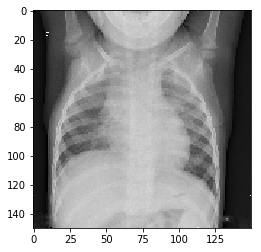

Normal


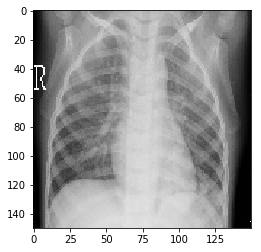

Pneumonia


In [18]:
plt.imshow(img1)
plt.show()
if res1[0][0] <= 0.5:
  print("Pneumonia")
else:
  print('Normal')  
plt.imshow(img2)
plt.show()
if res2[0][0] <= 0.5:
  print("Pneumonia")
else:
  print('Normal') 